## EM-example
Demonstrating with GMM

Building dataset and initialize variables, we define a gaussian mixturemodel to fit onto our dataset:

$$\sum w_i \mathcal{N}(\mu_i, \Sigma_i)$$

This requires us to find $3n$ variables $\mu_1 ... \mu_n$, $\Sigma_1 ... \Sigma_n$ and $w_1 ... w_n$. It also lets us  define $\mathcal{L}(\theta; X)$ (of course theta is all of the parameters earlier defined) with the realation:

$$\mathcal{L}(\theta; X) = \prod^n_i \sum^3_j w_j N(x_i; \mu_j, \Sigma_j)$$

$$log \mathcal{L}(\theta; X) = \sum^n_i log \sum^3_j w_j N(x_i; \mu_j, \Sigma_j)$$

We initialize our parameters randomly, though a better initialization could be:
- $\mu$ as the mean of our datapoints 
- $\Sigma$ as the mean square error from the mean, $\frac{1}{n}\sum^n_{i=1} (x_i - \mu)^2$ 
- $w$ as just an even part for each cluster we are estimating $\frac{1}{3}$


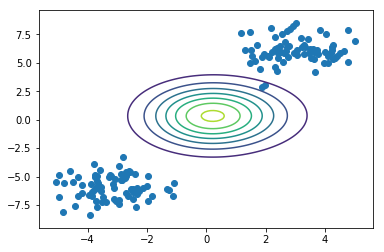

mean [[-0.01640068  0.29282135]
 [ 0.68526471  0.37605566]]
cov [array([[1.75253408, 0.        ],
       [0.        , 3.24287601]]), array([[2.72424225, 0.        ],
       [0.        , 3.39736671]])]


In [2130]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

def plot_multinormal_mixtures(models, w, lim_x = (-12, 12), lim_y = (-10, 10)):
    x, y = np.mgrid[lim_x[0]:lim_x[1]:.1, lim_y[0]:lim_y[1]:.1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    out = w[0]*models[0].pdf(pos)
    for i in range(1,len(models)):
        out = out + w[i]*models[i].pdf(pos)
    plt.contour(x, y, out)
    
K = 2
number_samples = 150
Out, label = datasets.make_blobs(n_samples=number_samples, n_features=K, centers=[[3, 6], [-3, -6]])
X = Out[:, 0]
Y = Out[:, 1]

mean = np.zeros((2, K))
cov = [((0, 0), (0, 0))] * K
w = [1/K] * K
n = [None] * K

for k in range(0, K):
    mean[k] = np.random.uniform(-1, 1, size=(2))
    cov[k] = np.random.uniform(0.5, 4, size=(2,2))*np.identity(2)
    
    n[k] = multivariate_normal(mean[k], cov[k])
    
plot_multinormal_mixtures(n, w, lim_x = (min(X), max(X)), lim_y = (min(Y), max(Y)))
plt.scatter(X, Y)
plt.show()

print('mean', mean)
print('cov', cov)

In [2122]:
def plot_map(w, mean, cov, save=False, name='0'):
    n = [multivariate_normal(mean[i], cov[i], allow_singular=True) for i in range(0,K)]

    A0 = w[0]*multivariate_normal(mean[0], cov[0], allow_singular=True).pdf(pos)
    A1 = w[1]*multivariate_normal(mean[1], cov[1], allow_singular=True).pdf(pos)
    c = [0 if p < A1[i] else 1 for i, p in enumerate(A0)]

    plt.scatter(X, Y, c=c)
    plot_multinormal_mixtures(n, w, lim_x = (min(X), max(X)), lim_y = (min(Y), max(Y)))
    if save:
        plt.savefig('em-save/'+str(name)+'.png')
    plt.show()

## E-step
Now we define our expectation as:
$$Q(\theta \mid \theta_t) = E[log \mathcal{L}(\theta; X)]$$

Now we also can define the distribution $P(x_i \mid K = 1) = T_{ik}$ which is the probability that $x_i$ belongs to cluster $k$.

$$T_{ik} = \frac{w_k N(x_i \mid \mu_k, \Sigma_k)}{\sum^3_{j=1} w_j N(x_i \mid \mu_j, \Sigma_j)}$$

Looking at the expectation per cluster $k$:

$$E_k[log \mathcal{L}(\theta; X)] = E_k[log (\prod^n_i w_k N(x_i \mid \mu_k, \Sigma_k))] $$
$$= E_k[\sum^n_i (log(w_i) + log  N(x_i \mid \mu_k, \Sigma_k))]$$
$$= E_k[\sum^n_i (log(w_i) + log \frac{1}{\sqrt{(2\pi)^K|\Sigma|}} - \frac{(x_i - \mu_k)^T\Sigma^{-1}(x_i - \mu_k)}{2})]$$

## M-step
Now we can get our final updated varialbes:
- $w_k = \sum^n_{i=1} \frac{T_{ik}}{n}$
- $\mu_k = \frac{\sum^n_{i=1} T_{ik} x_i}{\sum^n_{i=1} T_{ik}}$
- $\Sigma_k = \frac{\sum^n_{i=1} T_{ik} (x_i - \mu_k)(x_i - \mu_k)^T}{\sum^n_{i=1} T_{ik}}$

_These are retrived by differentiating the expectation defined above_ 

Then we compare our $Q_t$ with the old $Q_{t-1}$ if no change is present we are done else we repeat the E-step.

In [2131]:
pos = np.array((X, Y)).T
def get_total():
    t = np.multiply(w[0], multivariate_normal(mean[0], cov[0], allow_singular=True).pdf(pos))
    for s in range(1, K):
        t = np.add(t, np.multiply(w[s], multivariate_normal(mean[s], cov[s], allow_singular=True).pdf(pos)))
    return t

def get_score(Tn):
    t = np.sum(Tn[0] * (np.log(w[0]) + np.log(multivariate_normal(mean[0], cov[0], allow_singular=True).pdf(pos))))
    for s in range(1, K):
        t += np.sum(Tn[k] * (np.log(w[k]) + np.log(multivariate_normal(mean[k], cov[k], allow_singular=True).pdf(pos))))
    return t
    #return np.sum((pos - mean[k]) @ np.linalg.inv(cov[k]) @ (pos - mean[k]).T)

def calculate_T():
    total = get_total()
    t = np.zeros((K, len(pos)))
    for k in range(0, K):
        t[k] = w[k] * multivariate_normal(mean[k], cov[k], allow_singular=True).pdf(pos) / total
    return t

error = 0.5

T = calculate_T()
Q_old = get_score(T)

t_sum = np.sum(T, axis=1)

stats = False
if stats:
    plot_map(w, mean, cov, save=False, name=0)

for step in range(1000):
    # e-step, defining T
    T = calculate_T()
    Q_old = get_score(T)
    
    # m-step, updating parameters
    for k in range(0, K):
        w[k] = np.sum(T[k])/len(T[k])
        
        mean[k][0] = np.sum(np.multiply(T[k], pos[:, 0]))/t_sum[k]
        mean[k][1] = np.sum(np.multiply(T[k], pos[:, 1]))/t_sum[k]
        
        #mean[k] = np.sum(np.transpose((T[k], T[k])) * pos, axis=0)/t_sum[k]
        
        #sig_x = np.sum(np.multiply(T[k], (pos[:, 0] - mean_x)**2))/t_sum
        #sig_y = np.sum(np.multiply(T[k], (pos[:, 1] - mean_y)**2))/t_sum
        
        #sig = np.sum((T[k], T[k]) @ (pos - mean[k]) @ (pos - mean[k]).T, axis=1)/t_sum
        #cov[k] = [[sig[0], 0], [0, sig[1]]]
        
        cov[k] = (((T[k], T[k]) * (pos - np.array(mean[k])).T) @ (pos - np.array(mean[k])))/t_sum[k]
        
        t_sum[k] = np.sum(T[k])
        
        
    
    T = calculate_T()
    Q = get_score(T)

    if stats:
        plot_map(w, mean, cov, save=False, name=step+1)
        print('mean', mean)
        print('cov', cov)
    print('Q', Q_old, Q)
    if Q_old + 0 >= Q:
        print('converged', step)
        break
        

Q -1692.1480401090103 -784.5512744741922
Q -784.5512744741922 -779.7163982731845
Q -779.7163982731845 -770.2266752451393
Q -770.2266752451393 -747.5956809631441
Q -747.5956809631441 -691.8745065975079
Q -691.8745065975079 -672.7878168467843
Q -672.7878168467843 -605.6927787106933
Q -605.6927787106933 -542.7916077919688
Q -542.7916077919688 -529.1181305350774
Q -529.1181305350774 -529.0977471212029
Q -529.0977471212029 -529.0977471212029
converged 10


w [0.5, 0.5]
mean [[-3.19551673 -5.91760082]
 [ 3.03385274  6.07807392]]
cov [array([[0.83921449, 0.02719589],
       [0.02719589, 1.08505146]]), array([[0.94221562, 0.0768613 ],
       [0.0768613 , 1.15559118]])]


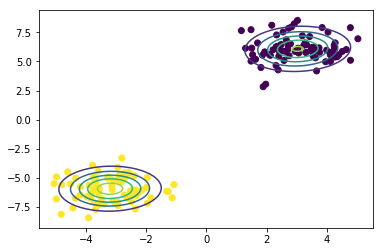

In [2132]:
print('w', w)
print('mean', mean)
print('cov', cov)

plot_map(w, mean, cov)